In [7]:
import matplotlib.pyplot as plt
import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
from models import *
import torch
import torch.optim
from skimage import io
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import cv2
from utils.sr_utils import *
from models.down_otf_nn import down_otf_nn
from utils.get import get_AiryDisk as get_otf
from utils.get import get_3d 
from utils.tv_loss import tv_loss
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
PLOT = True
filename='data/'#Image folder location
save_path=filename+'10/'## Folder location for output
path_to_image1 = filename+'sim_ccp.tiff'## Low resolution image
path_to_image2=path_to_image1 
Multiple_pixel=1 ### Need to double the pixels?


In [8]:
imgs = load_img(path_to_image1,path_to_image2 , imsize=-1)
######
## Microscope system parameter
crop_img_size=imgs['HR_pil'].size[1]
factor1=1
NA = 1.7*(1+1) ## Effective NA；Sim reconstruction, equivalent to 2 times the NA value
wavelength = 509
sizePixel = 3.25
MA = 100
CF = 1
factor2=0.9 #You can fine-tune this factor to get the best super-resolution image
######
psf, otf = get_otf(crop_img_size, NA, wavelength, sizePixel, MA, CF,factor1,factor2)
otf=otf.astype('float32')
tv_w = 0.00000001
####
##########
input_depth=1
net = get_net(input_depth,'unet1').type(dtype)# Skip networks in the DIP article can also be used
##########

HR and LR resolutions: (512, 512), (512, 512)


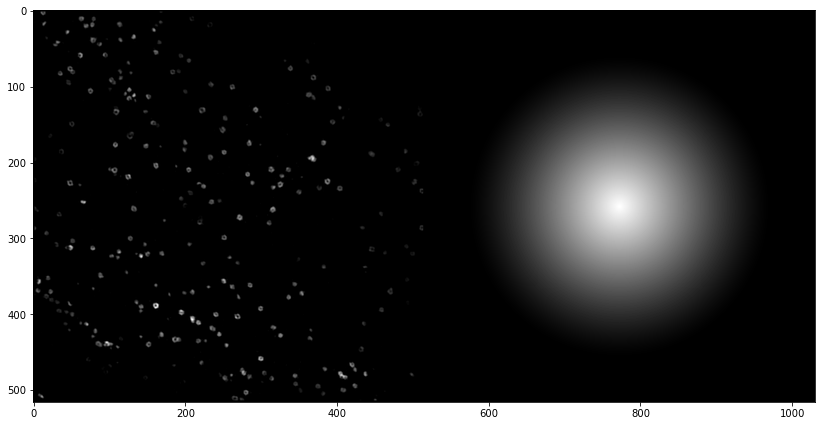

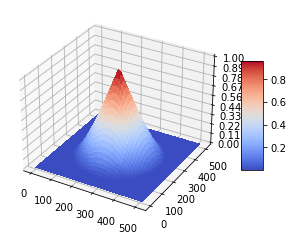

In [9]:
###wf load
if PLOT:
    plot_image_grid([imgs['HR_np'], otf[None,:,:]], 2,12);
get_3d(otf,imgs['HR_pil'].size[1],1)

In [10]:
if Multiple_pixel>1:
    otf=cv2.resize(otf, (Multiple_pixel*imgs['HR_pil'].size[1],Multiple_pixel*imgs['HR_pil'].size[0]))
otf=otf[None,None,:,:]
otf=torch.from_numpy(otf)
otf=otf.cuda()
mse = torch.nn.MSELoss().type(dtype)
mae=torch.nn.L1Loss().type(dtype)
temp_data=imgs['LR_np'][0,:,:]
if Multiple_pixel>1:
    temp_data=cv2.resize(temp_data,(Multiple_pixel*imgs['HR_pil'].size[1],Multiple_pixel*imgs['HR_pil'].size[1]),cv2.INTER_LANCZOS4)
temp_data2=temp_data[None,:,:]
img_LR_var = np_to_torch(temp_data2).type(dtype)
net_input=img_LR_var 

In [11]:
def Iteration():
    global i,net_input
    out_HR = net(net_input)
    out_LR=down_otf_nn.forward(out_HR,otf)
    total_loss =mae(out_LR, img_LR_var)+0*mse(out_LR,img_LR_var)
    total_loss += tv_w * tv_loss(out_HR)
    total_loss.backward()
    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], imgs['HR_np'])
    ssim_LR=compare_ssim(imgs['HR_np'][0,:,:],imgs['LR_np'][0,:,:])
    psnr_value.append([psnr_LR])
    print ('Iteration %05d    ' % (i), '\r', end='')
    i += 1
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        out_HR_np1=out_HR_np
        plot_image_grid([temp_data2, out_HR_np1], factor=13, nrow=2)

    if PLOT and i % 10 == 0:
        out_out = np.clip(torch_to_np(net(net_input)), 0, 1)
       # print(np.max(np.max(out_out)))
        out=out_out*65535/1
        #out=out_out
        out=out.astype('uint16')
        if i>=100 and i<1000:
            io.imsave(save_path+'/sim_HR_iter'+'00'+str(i)+'.tif',out)
        elif i>=1000:
            io.imsave(save_path+'/sim_HR_iter'+'0'+str(i)+'.tif',out)
    return total_loss
def get_params1(net):
    params = []
    params += [x for x in net.parameters()]
    return params
def opt(para_temp,Iteration, LR, num_iter):
    optimizer = torch.optim.Adam(para_temp, lr=LR)
    for j in range(num_iter):
        optimizer.zero_grad()
        Iteration()
        optimizer.step()

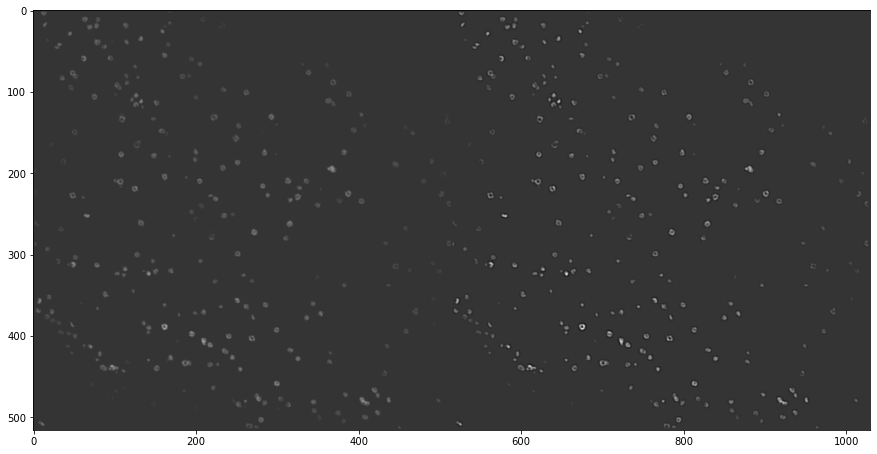

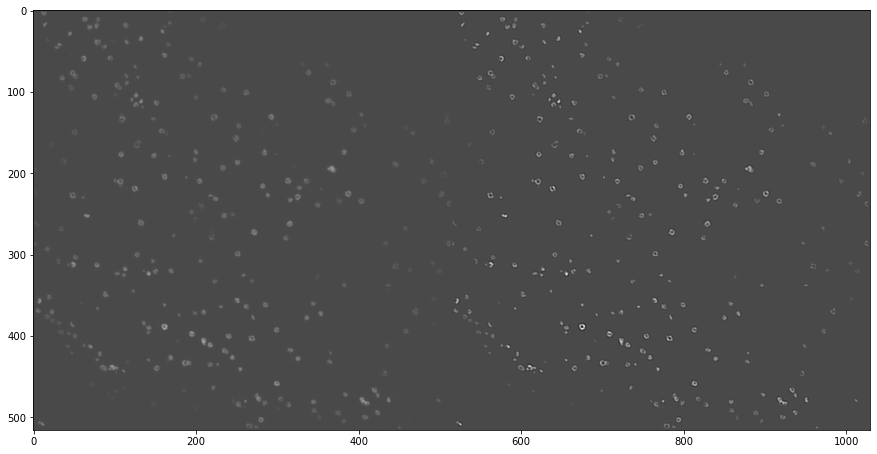

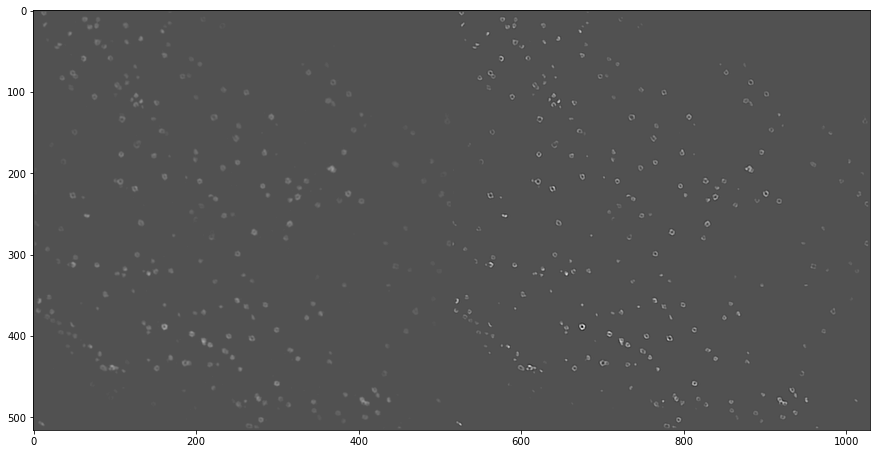

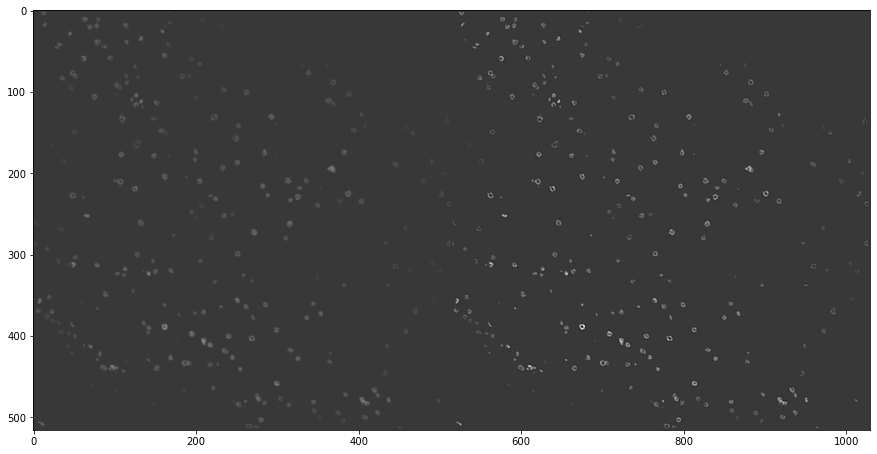

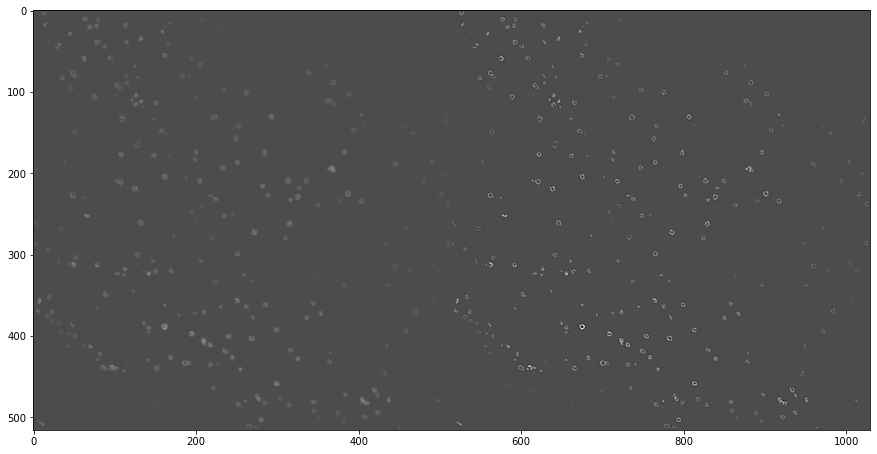

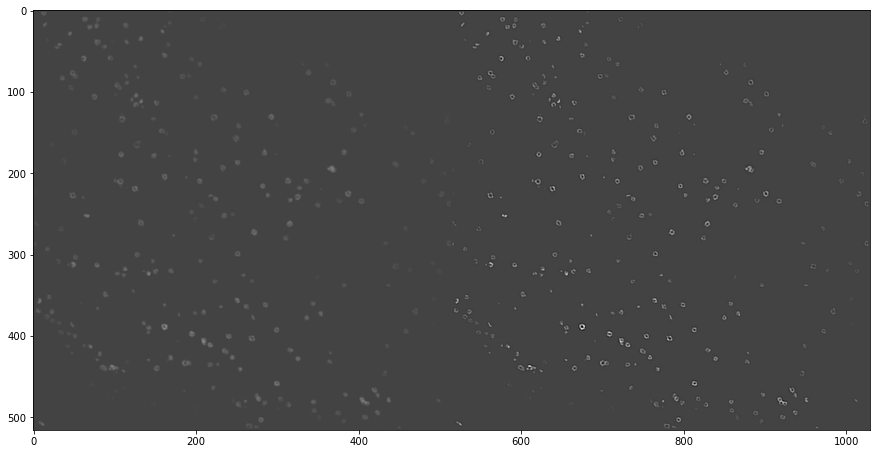

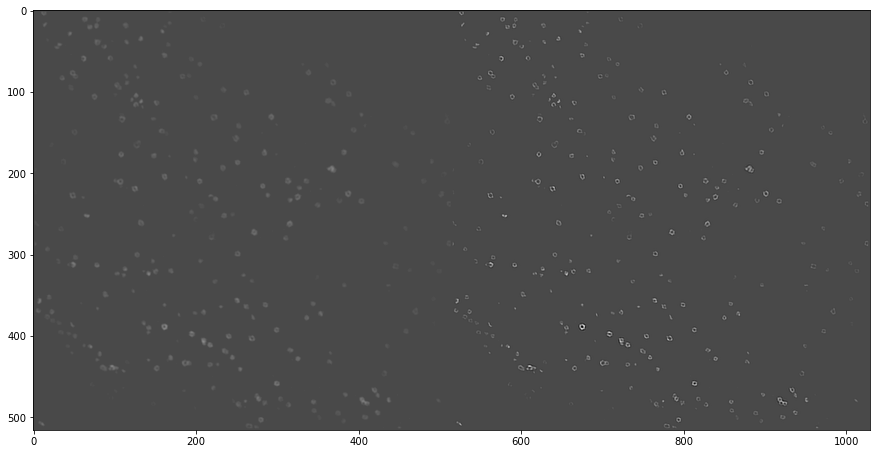

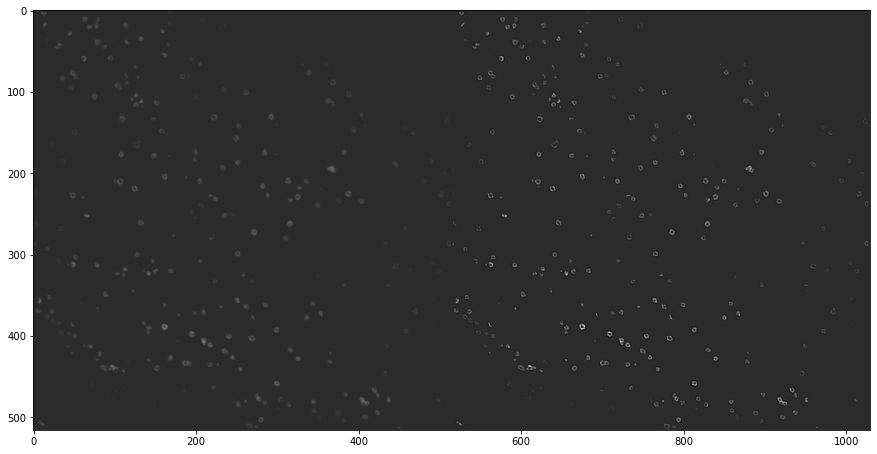

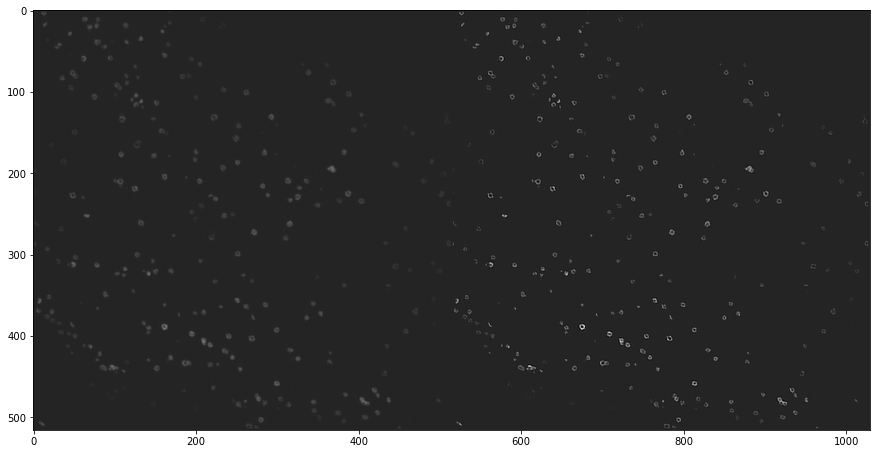

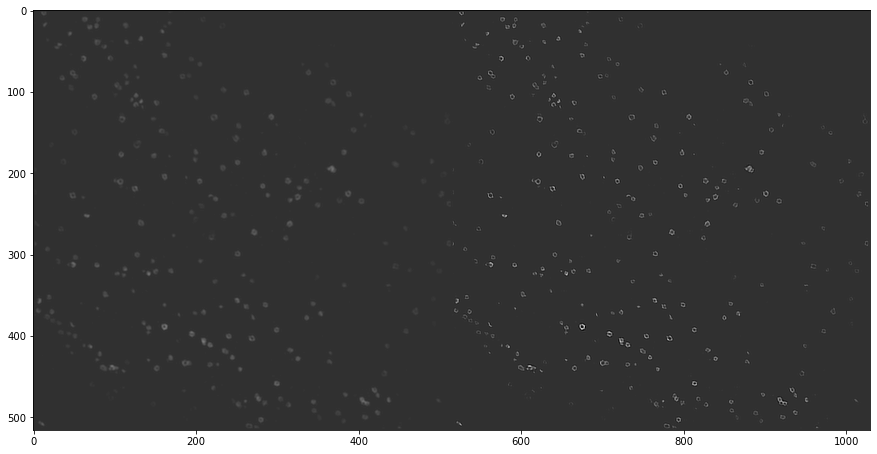

KeyboardInterrupt: 

In [12]:
psnr_value = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
num_iter = 3000
i = 0

LR=0.01
opt(get_params1(net),Iteration, LR, num_iter)